<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/New_Attack_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
import scipy.stats as st

from tqdm import tqdm
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import tensorflow
import numpy
import matplotlib.pyplot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Pre-procesing

## Get working df

In [4]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)
  
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

### Cutoff main

In [5]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df
  
def main_cutoff(input_path):
  print('Reading data from file.')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  df.iloc[0].fillna(method='bfill', inplace=True)
  df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  cut_point = cut_off_idx(df)
  working_df = select_working_data(df, cut_point)

  return working_df

In [6]:
#input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"
#orking_df = main_cutoff(input_path)
#display(working_df)

#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

# Get data

In [7]:
input_path = path + "/Spectrum/NN/new_data_working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [8]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, 6:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

In [9]:
def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 3000):
  X=None
  Y=np.array([])
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]
  samples_df = pd.merge(dist_df, freq_df, left_index=True, right_index=True)
  samples_df = samples_df.sort_values(by='Distance_km')
  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 0].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 1:samples_df.shape[1]]
  
  return X, Y, samples_df

In [10]:
#input_data_path=path+"/rawData"
#distances=[i for i in range(1,26)]
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 'all', span_length=80,  min_dist = 0, max_dist = 3000)

In [11]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-30.766774,-35.433400,-39.636295,-39.572805,...,-36.158246,-34.974566,-33.677152,-32.461789,-31.697031,-30.033924,-33.492361,-34.387412,-33.308819,-30.242322
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.063281,-32.262853,-35.781499,-35.580851,...,-32.811077,-33.647974,-34.523244,-34.873656,-38.167460,-35.568105,-38.499464,-41.863667,-44.503764,-46.884585
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-32.485086,-34.725450,-31.833082,-35.461288,...,-39.867905,-42.487405,-36.881447,-32.796440,-31.492113,-36.181981,-36.404388,-32.599868,-32.605291,-35.086710
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.223232,-30.862095,-28.720843,-31.102346,...,-34.051539,-35.013313,-33.634516,-34.267799,-36.189625,-35.279263,-33.557900,-30.107759,-31.016528,-34.939487


## Attack

In [12]:
# source_df = data that is wished to be modified
# target_df = data that the source would convert

source_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == 2000]
target_df = samples_filtered_df.loc[samples_filtered_df['Distance_km'] == 80]

In [13]:
def get_eval_data(source_df, target_df, num_eval_samples = 10):
  import random
  source_val_list = [i for i in range(1, len(source_df))]
  source_random_list = random.choices(source_val_list, k = num_eval_samples)

  target_val_list = [i for i in range(1, len(target_df))]
  target_random_list = random.choices(target_val_list, k = num_eval_samples)

  eval_source_df = source_df.iloc[source_random_list]
  eval_target_df = target_df.iloc[target_random_list]

  return eval_source_df, eval_target_df

In [14]:
eval_source_df, eval_target_df = get_eval_data(source_df, target_df, num_eval_samples = 10)

In [15]:
def get_ci(df, alpha = 0.90):
  ci_arr = []
  for i in range(1, df.shape[1]):
    eval_col = df.iloc[:,i].to_numpy()
    source_ci = st.t.interval(alpha=alpha, df=len(eval_col)-1, loc=np.mean(eval_col), scale=st.sem(eval_col))
    ci_arr.append(source_ci)
  return ci_arr

In [16]:
source_ci_arr = get_ci(eval_source_df, alpha = 0.90)
target_ci_arr = get_ci(eval_target_df, alpha = 0.90)
print(source_ci_arr)

[(-38.17750865882653, -31.261190802698657), (-36.78637752138095, -32.855756328367086), (-37.04058740795151, -32.58279506524661), (-36.100202191325515, -32.63386010264424), (-36.6171043289855, -33.270661888955225), (-36.9403208020068, -32.07574868633261), (-36.991362016072806, -32.851729770951074), (-37.23276839954762, -33.08442496428471), (-36.54522853596505, -32.8878861932768), (-36.78849981610188, -32.83688740874184), (-38.37859945267505, -32.0935102532048), (-38.51029375452861, -34.85023856575574), (-39.206058377988136, -34.569246842838076), (-37.23660529812163, -33.164352069835346), (-34.058448539151534, -30.914225767955664), (-35.86996522709541, -32.28366039634867), (-38.459846271928505, -33.1773394592125), (-37.9007060949086, -33.53930967870599), (-35.692043942661606, -30.47203789501753), (-36.29981063147744, -32.999095759749466), (-37.21371972940904, -33.46961387842938), (-37.216492324310465, -33.641359058768614), (-36.5058447519336, -33.010280817540156), (-36.862252134548314, -

In [17]:
eval_source_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
324,2000,-32.451171,-31.618634,-31.529087,-33.766986,-31.565257,-32.676494,-35.149459,-40.610394,-37.495338,...,-32.478527,-36.716726,-39.651480,-38.022395,-33.948809,-27.570582,-32.637762,-36.906655,-37.356209,-34.246370
549,2000,-29.647082,-33.344067,-36.295045,-38.596378,-37.882390,-36.714067,-36.002122,-33.826162,-30.427170,...,-33.226097,-27.865405,-27.100636,-27.029330,-29.732257,-31.756414,-33.376481,-31.568604,-31.092932,-31.093482
1224,2000,-32.673174,-32.016875,-32.726750,-33.304902,-36.421429,-39.062857,-33.759186,-35.252007,-34.629236,...,-28.980579,-32.711174,-34.828786,-34.781917,-37.839232,-34.907503,-31.193354,-39.178739,-43.012425,-47.776193
274,2000,-29.095923,-38.051929,-41.016294,-35.643827,-35.858224,-32.730524,-37.046773,-32.454232,-30.989603,...,-35.340303,-31.121095,-26.822242,-28.471064,-31.833300,-39.353877,-44.268863,-43.957527,-38.845434,-29.259279
924,2000,-30.074150,-28.903182,-28.602393,-28.130953,-30.652741,-33.009925,-34.878121,-35.950148,-38.651720,...,-28.247974,-34.223588,-36.698982,-33.562229,-28.742611,-33.747860,-37.681633,-39.367118,-37.087335,-31.483462
499,2000,-31.682413,-35.059191,-36.414279,-36.100157,-35.080896,-33.062969,-29.850232,-29.131301,-31.571874,...,-34.218514,-32.145878,-34.806670,-34.640646,-31.879416,-30.720532,-34.072540,-32.852711,-39.473714,-50.343123
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-30.766774,-35.433400,-39.636295,-39.572805,...,-36.158246,-34.974566,-33.677152,-32.461789,-31.697031,-30.033924,-33.492361,-34.387412,-33.308819,-30.242322
174,2000,-48.491479,-36.878006,-31.016251,-34.208686,-35.799508,-32.493126,-31.795738,-31.877750,-34.293921,...,-42.743944,-37.066690,-47.680026,-42.834290,-41.054633,-28.046799,-29.692658,-31.225033,-34.657142,-40.572830
674,2000,-35.627781,-35.065245,-34.914735,-32.586981,-39.946572,-43.935612,-42.989319,-34.775091,-35.216793,...,-34.880480,-35.693374,-32.854614,-31.063207,-30.239754,-33.441726,-32.791016,-35.734261,-41.768889,-50.169310
1874,2000,-38.389907,-37.183826,-36.417766,-38.009742,-33.837234,-30.627998,-32.311109,-38.072588,-34.317112,...,-34.916698,-34.300712,-38.181949,-35.319235,-37.703552,-38.035869,-36.975525,-30.407371,-28.629908,-30.068479


# Variable Auto-Encoder

In [ ]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-30.766774,-35.433400,-39.636295,-39.572805,...,-36.158246,-34.974566,-33.677152,-32.461789,-31.697031,-30.033924,-33.492361,-34.387412,-33.308819,-30.242322
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.063281,-32.262853,-35.781499,-35.580851,...,-32.811077,-33.647974,-34.523244,-34.873656,-38.167460,-35.568105,-38.499464,-41.863667,-44.503764,-46.884585
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-32.485086,-34.725450,-31.833082,-35.461288,...,-39.867905,-42.487405,-36.881447,-32.796440,-31.492113,-36.181981,-36.404388,-32.599868,-32.605291,-35.086710
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.223232,-30.862095,-28.720843,-31.102346,...,-34.051539,-35.013313,-33.634516,-34.267799,-36.189625,-35.279263,-33.557900,-30.107759,-31.016528,-34.939487


## Encoder

In [ ]:
# Bottleneck size
latent_dim = 256
samples_data_filtered_df = samples_filtered_df.iloc[:, 1:samples_filtered_df.shape[1]]

training_dataset = samples_data_filtered_df

shape_data = samples_data_filtered_df.shape
input_shape = shape_data[1]

In [ ]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add

from tensorflow.keras.optimizers import Adam

from keras import backend as K

K.clear_session()

In [ ]:

encoder_input = Input(shape = input_shape)

x = Dense(32, activation = 'relu')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128]
for i in filter_size:
    x = Dense(i, activation = 'relu')(x)
    x = BatchNormalization()(x)
x = Flatten()(x)
encoder_output = Dense(256, activation = selu)(x)

mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
#encoder.summary()


In [ ]:

decoder = Sequential()
decoder.add(Dense(512, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(4096, activation = selu))
decoder.add(Reshape((4,4,256)))

decoder.add(Dense(128, activation = 'relu'))
decoder.add(BatchNormalization())

decoder.add(Dense(64, activation = 'relu'))
decoder.add(BatchNormalization())

decoder.add(Dense(32, activation = 'relu'))
decoder.add(BatchNormalization())

decoder.add(Dense(input_shape, activation = 'relu'))
decoder.add(BatchNormalization())
#decoder.summary()

In [ ]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [ ]:

# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
#model.summary()

In [ ]:
# train vae
mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
  for step, training_batch in enumerate(training_dataset):
    print(step)
    print(training_batch)
    with tf.GradientTape() as tape:
      reconstructed = model(training_batch)
      y_true = tf.reshape(training_batch, shape = [-1])
      y_pred = tf.reshape(reconstructed, shape = [-1])
      
      mse_loss = reconstruction_loss(y_true, y_pred)
      mse_losses.append(mse_loss.numpy())
      
      kl = sum(model.losses)
      kl_losses.append(kl.numpy())
      
      train_loss = 0.01 * kl + mse_loss
      
      grads = tape.gradient(train_loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
  print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

0
-39.90625


TypeError: ignored

# Try 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from tensorflow.keras import objectives
from keras.datasets import mnist
# Hyperparameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 10
epsilon_std = 1.0

ImportError: ignored

In [ ]:
#encoder
x = Input(batch_shape = (batch_size, original_dim))
h = Dense(intermediate_dim, activation = 'relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
print(z_mean)
print(z_log_var)

KerasTensor(type_spec=TensorSpec(shape=(100, 2), dtype=tf.float32, name=None), name='dense_13/BiasAdd:0', description="created by layer 'dense_13'")
KerasTensor(type_spec=TensorSpec(shape=(100, 2), dtype=tf.float32, name=None), name='dense_14/BiasAdd:0', description="created by layer 'dense_14'")


In [ ]:
def sampling(args):
 z_mean, z_log_var = args
 epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
 return z_mean + K.exp(z_log_var / 2) * epsilon
 
# note that “output_shape” isn’t necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#latent hidden state
print(z)

KerasTensor(type_spec=TensorSpec(shape=(100, 2), dtype=tf.float32, name=None), name='lambda/add:0', description="created by layer 'lambda'")


In [ ]:
#decoder
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print(x_decoded_mean)

KerasTensor(type_spec=TensorSpec(shape=(100, 784), dtype=tf.float32, name=None), name='dense_16/Sigmoid:0', description="created by layer 'dense_16'")


In [ ]:
#loss
def vae_loss(x, x_decoded_mean):
 xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
 kl_loss = — 0.5 * K.sum(1 + z_log_var — K.square(z_mean) — K.exp(z_log_var), axis=-1)
 return xent_loss + kl_loss
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss

In [ ]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(‘float32’) / 255.
x_test = x_test.astype(‘float32’) / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
vae.fit(x_train, x_train,
 shuffle=True,
 nb_epoch=nb_epoch,
 batch_size=batch_size,
 validation_data=(x_test, x_test),verbose=1)

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
 for j, xi in enumerate(grid_y):
 z_sample = np.array([[xi, yi]])
 x_decoded = generator.predict(z_sample)
 digit = x_decoded[0].reshape(digit_size, digit_size)
 figure[i * digit_size: (i + 1) * digit_size,
 j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap=’Greys_r’)
plt.show()

# Fail 3

In [ ]:
import tensorflow
import numpy
import matplotlib.pyplot

## encoder

In [ ]:
img_size = 28
num_channels = 1
latent_space_dim = 2

# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
#encoder.summary()

## decoder

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
#decoder.summary()

## vae

In [ ]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 2)                 106130    
                                                                 
 decoder_model (Functional)  (None, 28, 28, 1)         121537    
                                                                 
Total params: 227,667
Trainable params: 226,833
Non-trainable params: 834
_________________________________________________________________


## loss and compile

In [ ]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## load dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = numpy.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = numpy.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

history = vae.fit(x_train, x_train, epochs=3, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/3
1875/1875 [==============================] - 401s 212ms/step - loss: 63.0748 - val_loss: 55.6309
Epoch 2/3
1875/1875 [==============================] - 379s 202ms/step - loss: 53.0148 - val_loss: 51.0353
Epoch 3/3
1875/1875 [==============================] - 377s 201ms/step - loss: 50.1363 - val_loss: 49.0030


## vizualize loss

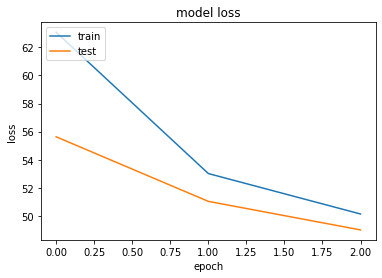

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## save model

In [ ]:
encoder.save(path+"/Spectrum/attack/autoencoder/VAE_encoder.h5") 
decoder.save(path+"/Spectrum/attack/autoencoder/VAE_decoder.h5") 
vae.save(path+"/Spectrum/attack/autoencoder/VAE.h5")

## test model

In [ ]:
encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_encoder.h5", compile=False)
decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_decoder.h5", compile=False)

# Preparing MNIST Dataset
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0

x_test = numpy.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

313/313 [==============================] - 15s 46ms/step


## vizualize prediction

In [ ]:
print(decoded_data.shape)

(10000, 28, 28, 1)


In [ ]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    print(img[0].shape)
    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img[0])

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco[0])
    plt.show()

for i in range(2):
    img = x_test[i]
    visualize(img,encoder,decoder)

1/1 [==============================] - 0s 31ms/step
(28, 1)


# VAE MOD

In [82]:
import tensorflow
import numpy
import matplotlib.pyplot

In [83]:
input_size = samples_filtered_df.shape[1] - 1

## encoder

In [84]:
latent_space_dim = 2

# Encoder
x = tensorflow.keras.layers.Input(shape=(input_size), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=32, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=32, name="encoder_dense_2")(encoder_activ_layer1)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_dense_layer2)

encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_3")(encoder_activ_layer2)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_dense_layer3)

encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_4")(encoder_activ_layer3)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_dense_layer4)

encoder_dense_layer5 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_5")(encoder_activ_layer4)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_dense_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

## decoder

In [85]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_input_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_input_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_input_layer1)

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_1")(decoder_reshape)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_2")(decoder_activ_layer1)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_dense_layer2)

decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_3")(decoder_activ_layer2)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_dense_layer3)

decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=input_size, name="decoder_dense_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer4)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

## vae

In [86]:
vae_input = tensorflow.keras.layers.Input(shape=(input_size), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 2397)]            0         
                                                                 
 encoder_model (Functional)  (None, 2)                 88484     
                                                                 
 decoder_model (Functional)  (None, 2397)              168477    
                                                                 
Total params: 256,961
Trainable params: 256,961
Non-trainable params: 0
_________________________________________________________________


## loss and compile

In [87]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

## load dataset and train

In [88]:
samples_filtered_df

,Distance_km,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,-39.71875,-39.6875,-39.65625,...,34.6875,34.71875,34.75,34.78125,34.8125,34.84375,34.875,34.90625,34.9375,34.96875
0,80,-65.158556,-66.359675,-66.708836,-71.777931,-66.092081,-53.716181,-56.447556,-55.216247,-54.921922,...,-59.107222,-62.993632,-54.834111,-54.361885,-64.653201,-69.901475,-61.469377,-54.784317,-55.229285,-61.405108
125,80,-54.902319,-57.469566,-58.650167,-58.256577,-57.120871,-54.832446,-56.585764,-58.167556,-57.408129,...,-57.627135,-64.548644,-65.637002,-63.156643,-58.177577,-59.985663,-58.031358,-60.922607,-59.679082,-56.034034
975,80,-55.246289,-58.903165,-59.936123,-58.754704,-53.084186,-50.990158,-51.881985,-58.366417,-61.236644,...,-58.538788,-60.779631,-60.445396,-60.851264,-59.971745,-59.222002,-61.642559,-61.885148,-61.544703,-59.897084
1000,80,-58.769150,-60.644357,-61.903338,-66.371732,-60.697843,-58.893096,-60.500364,-63.977091,-61.713541,...,-61.793840,-58.908770,-60.404921,-60.130890,-61.535060,-55.319260,-59.725285,-63.973778,-61.619858,-53.937357
1025,80,-62.672232,-63.551920,-63.130158,-61.900052,-61.208010,-62.534571,-63.881451,-61.861091,-67.207673,...,-59.124382,-59.038588,-59.114337,-57.422896,-57.627687,-57.376619,-56.733160,-58.539036,-58.086162,-56.690199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-39.060418,-40.089715,-39.184312,-33.321699,-32.394581,-30.766774,-35.433400,-39.636295,-39.572805,...,-36.158246,-34.974566,-33.677152,-32.461789,-31.697031,-30.033924,-33.492361,-34.387412,-33.308819,-30.242322
1724,2000,-45.777276,-39.520381,-35.212366,-31.215854,-31.976366,-33.063281,-32.262853,-35.781499,-35.580851,...,-32.811077,-33.647974,-34.523244,-34.873656,-38.167460,-35.568105,-38.499464,-41.863667,-44.503764,-46.884585
1749,2000,-33.005394,-37.672756,-39.242985,-37.025965,-37.250896,-32.485086,-34.725450,-31.833082,-35.461288,...,-39.867905,-42.487405,-36.881447,-32.796440,-31.492113,-36.181981,-36.404388,-32.599868,-32.605291,-35.086710
2399,2000,-36.358480,-32.709908,-31.364002,-33.805751,-35.584646,-32.223232,-30.862095,-28.720843,-31.102346,...,-34.051539,-35.013313,-33.634516,-34.267799,-36.189625,-35.279263,-33.557900,-30.107759,-31.016528,-34.939487


In [89]:
def train_test_split(samples_filtered_df, train_size = 0.8, norm = True):
  for x in range(1, 26):
    distances_filtered = samples_filtered_df.loc[samples_filtered_df['Distance_km']==x*80]

    train_end = int(len(distances_filtered)*train_size)
    df_train = distances_filtered[:train_end]
    df_test = distances_filtered[train_end:]

    if x == 1:
      df_train_combined = df_train.copy()
      df_test_combined = df_test.copy()
    else:
      df_train_combined = pd.concat([df_train_combined, df_train], ignore_index=True)
      df_test_combined = pd.concat([df_test_combined, df_test], ignore_index=True)
  
  if norm == True:
    df_train_combined = (df_train_combined-df_train_combined.min())/ (df_train_combined.max() - df_train_combined.min())
    df_test_combined = (df_test_combined-df_test_combined.min())/ (df_test_combined.max() - df_test_combined.min())

  return df_train_combined, df_test_combined

In [90]:
def get_x_y_splits(df_train_combined, df_test_combined):
  y_train = df_train_combined['Distance_km'].tolist()
  x_train = []
  for i in range(len(df_train_combined)):
    x_train.append(df_train_combined.iloc[i, 1:df_train_combined.shape[1]].tolist())

  x_test = []
  for i in range(len(df_test_combined)):
    x_test.append(df_test_combined.iloc[i, 1:df_test_combined.shape[1]].tolist())
  y_test = df_test_combined['Distance_km'].tolist()

  return x_train, y_train, x_test, y_test

In [91]:
df_train_combined, df_test_combined = train_test_split(samples_filtered_df, train_size = 0.8, norm = True)
x_train, y_train, x_test, y_test = get_x_y_splits(df_train_combined, df_test_combined)

In [92]:
history = vae.fit(x_train, x_train, epochs=3, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# save autoencoder
encoder.save(path+"/Spectrum/attack/autoencoder/VAE_encoder.h5") 
decoder.save(path+"/Spectrum/attack/autoencoder/VAE_decoder.h5") 
vae.save(path+"/Spectrum/attack/autoencoder/VAE.h5")

Epoch 1/3


ValueError: ignored

## test model

In [ ]:
encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_encoder.h5", compile=False)
decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack/autoencoder/VAE_decoder.h5", compile=False)

# Preparing MNIST Dataset
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0

x_test = numpy.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)